In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
from IPython.display import HTML
import os
import dill

import numpy as np

from extravaganza.experiments import Experiment
from extravaganza.utils import get_color, render, ylim

# Load

In [2]:
# check all the saved experiments we can load
print('Experiments we can load:\n')
for fname in np.sort(os.listdir('../logs')):
    if '.pkl' not in fname: continue
    print('\t- {}'.format(fname[:-4]))

Experiments we can load:

	- mnist_0.15
	- mnist_0.15.pk
	- mnist_0.15_sequel
	- mnist_0.25_baseline_megalong
	- mnist_0.25_megalong
	- mnist_0.2_baseline_long
	- mnist_0.2_long
	- mnist_0.35
	- mnist_0.35_baseline_megalong
	- mnist_0.35_megalong
	- mnist_0.35_megalong_-k
	- pid


In [11]:
name = 'mnist_0.2_baseline_long'
filename = '../logs/{}.pkl'.format(name)
experiment = Experiment.load(filename)

INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
INFO: (EXPERIMENT) loaded experiment from `../logs/mnist_0.2_baseline_long.pkl`


In [3]:
e1 = Experiment.load('../logs/mnist_0.35_baseline_megalong.pkl')
e2 = Experiment.load('../logs/mnist_0.35.pkl')
e1.stats.update(e2.stats)

INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
INFO: (EXPERIMENT) loaded experiment from `../logs/mnist_0.35_baseline_megalong.pkl`
INFO: (EXPERIMENT) loaded experiment from `../logs/mnist_0.35.pkl`


# Plot

In [4]:
def plot(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 2
    nrows = n #+ (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            print('WARNING: {} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'lrs', label=method, color=get_color(method))
        stats.plot(ax[1, 0], 'train losses', label=method)
        stats.plot(ax[1, 1], 'avg train losses since reset', label=method)
#         i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbance norms', label=method)
#         stats.plot(i_ax, 'K @ state', label='K @ state')
#         stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
#         stats.plot(i_ax, 'M0', label='M0')
#         i_ax.set_title('u decomp for {}'.format(method))
#         i_ax.legend()
    
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('Learning Rate'); _ax.legend()#; ylim(_ax, -5, 20)
    _ax = ax[0, 1]; _ax.set_title('||Disturbance||'); _ax.legend()#; ylim(_ax, -0.5, 0.5)
    _ax = ax[1, 0]; _ax.set_title('Average Train Losses'); _ax.legend(); ylim(_ax, 0, 0.15)
    _ax = ax[1, 1]; _ax.set_title('Average Val Losses'); _ax.legend(); ylim(_ax, 0, 0.15)
    pass

<Figure size 640x480 with 0 Axes>

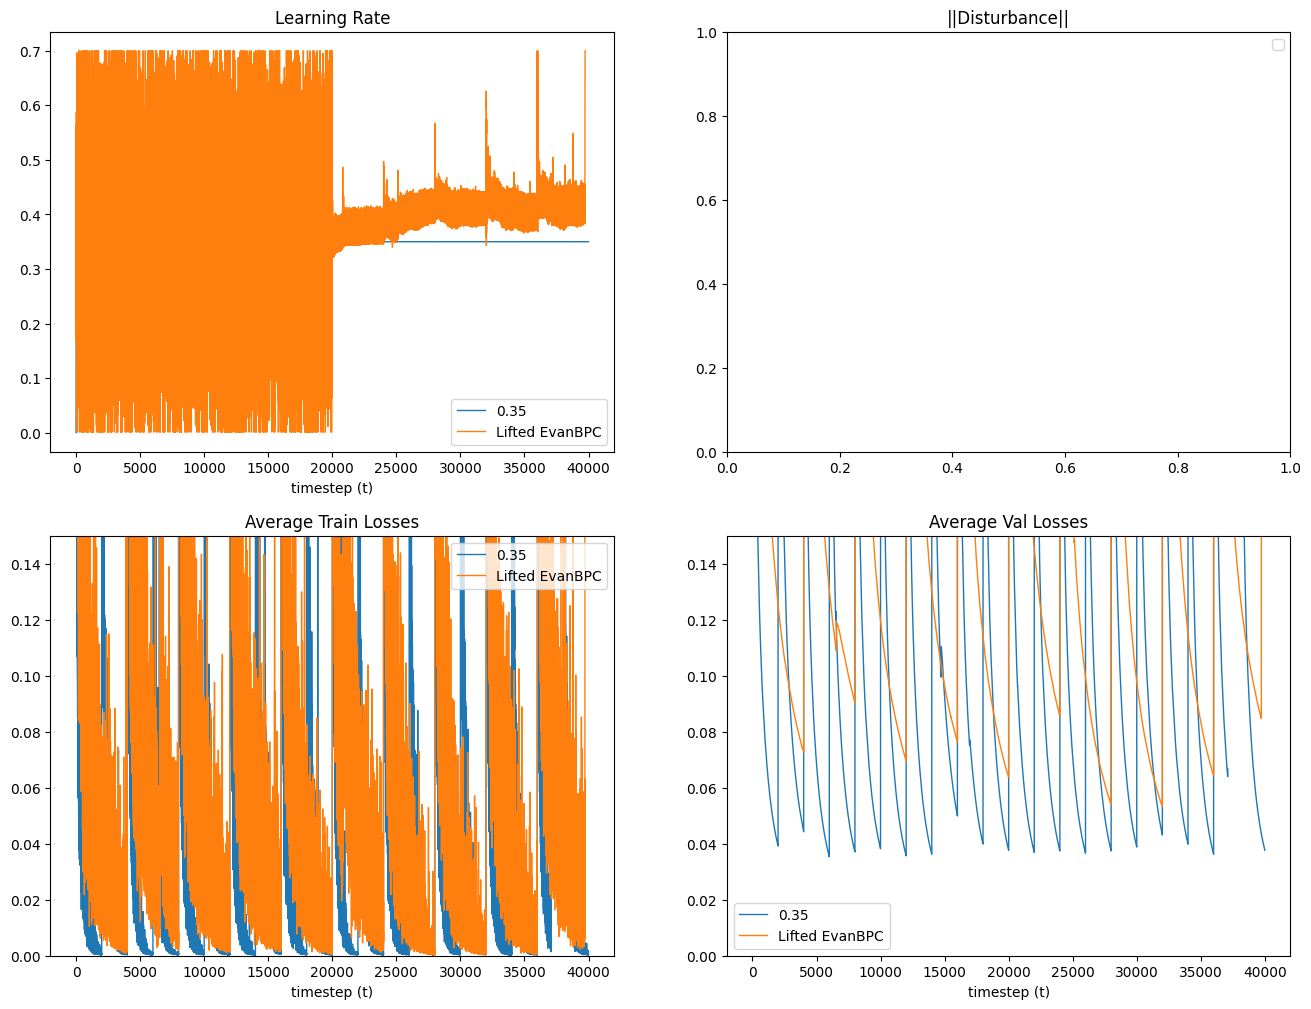

In [5]:
plot(e1)
# plt.savefig('../plots/{}.png'.format(name))

# Render

INFO: (RENDERER): rendering the stats of the following: ['0.2/0.1/0.1', 'Linear', 'Lifted']


AssertionError: unknown key(s)

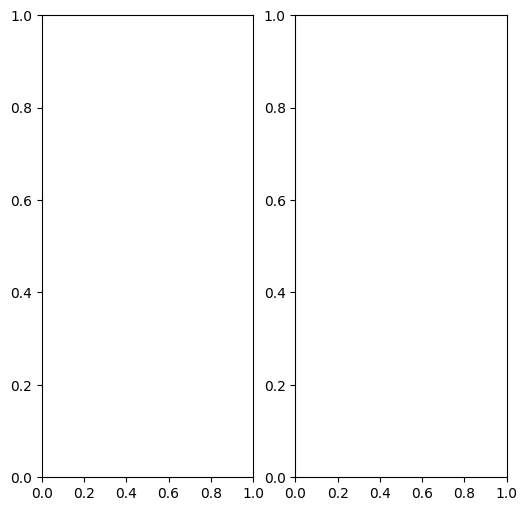

In [6]:
# dynamic plot
save_path = None # '../plots/{}.mp4'.format(name)
anim = render(experiment, 'xs', 'fs', sliderkey='us', save_path=save_path, duration=5, fps=30)
vid = anim.to_html5_video()
HTML(vid)

In [ ]:
def plot_lds(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 4
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            logging.warning('{} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'xs', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[3, 1], 'us', label=method)
        if 'costs' in stats:
            stats.plot(ax[1, 0], 'avg costs', label=method)
            stats.plot(ax[1, 1], 'costs', label=method)
        else:
            stats.plot(ax[1, 0], 'avg fs', label=method)
            stats.plot(ax[1, 1], 'fs', label=method)
    
        stats.plot(ax[2, 0], '||A||_op', label=method)
        stats.plot(ax[2, 1], '||B||_F', label=method)
        stats.plot(ax[3, 0], '||A-BK||_op', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('position'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('avg costs'); _ax.legend()
    _ax = ax[1, 1]; _ax.set_title('costs'); _ax.legend()
    
    _ax = ax[2, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[3, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('controls'); _ax.legend()
    pass

In [ ]:
plot_lds(experiment)